
# Pemodelan Dinamika Intensitas Cahaya (Lux) di Bandung  
_Jalur 1 – Sistem Dinamis Kontinu (ODE + RK4)_

Notebook ini dibuat untuk memenuhi tugas besar praktikum pemodelan dengan alur:

1. **Load Data**
2. **Exploratory Data Analysis (EDA)**
3. **Implementasi Model ODE + Metode Numerik (RK4)**
4. **Visualisasi & Evaluasi (Simulasi vs Data Riil)**

Studi kasus: **dinamika intensitas cahaya lingkungan (lux)** yang diukur sensor IoT di wilayah Bandung (data real dari Kaggle).



## 1. Import Library

Pada bagian ini kita memuat library yang dibutuhkan untuk:

- Manipulasi data: `pandas`, `numpy`
- Visualisasi: `matplotlib`
- Evaluasi model: metrik error dari `numpy`


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supaya grafik tampil di dalam notebook
%matplotlib inline

# Atur opsi tampilan pandas agar tabel lebih enak dibaca
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)



## 2. Load Data

Di bagian ini kita akan:

1. Membaca file `lux.csv`
2. Melihat beberapa baris pertama
3. Mengecek informasi kolom dan missing value

> **Catatan:**  
> - Pastikan file `lux.csv` berada di direktori kerja (misalnya di-root Colab / folder project Anda).  
> - Jika struktur path berbeda, silakan sesuaikan pada fungsi `read_csv`.


In [2]:

data_path = "dataset/lux.csv"

df_raw = pd.read_csv(data_path)
print("Ukuran data (rows, cols):", df_raw.shape)
df_raw.head()


Ukuran data (rows, cols): (433, 11)


,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement,device_id,orig_adapter
0,NaN,NaN,0,2021-10-11T10:05:49Z,2021-10-14T10:05:49.343Z,2021-10-11T10:10:00Z,398.3333,lux,telemetry,Upi_iotdev_9,hono-mqtt
1,NaN,NaN,0,2021-10-11T10:05:49Z,2021-10-14T10:05:49.343Z,2021-10-11T10:20:00Z,435.0000,lux,telemetry,Upi_iotdev_9,hono-mqtt
2,NaN,NaN,0,2021-10-11T10:05:49Z,2021-10-14T10:05:49.343Z,2021-10-11T10:30:00Z,NaN,lux,telemetry,Upi_iotdev_9,hono-mqtt
3,NaN,NaN,0,2021-10-11T10:05:49Z,2021-10-14T10:05:49.343Z,2021-10-11T10:40:00Z,188.3333,lux,telemetry,Upi_iotdev_9,hono-mqtt
4,NaN,NaN,0,2021-10-11T10:05:49Z,2021-10-14T10:05:49.343Z,2021-10-11T10:50:00Z,NaN,lux,telemetry,Upi_iotdev_9,hono-mqtt


In [3]:

# Informasi tipe data dan ringkasan kolom
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    0 non-null      float64
 1   result        0 non-null      float64
 2   table         433 non-null    int64  
 3   _start        433 non-null    object 
 4   _stop         433 non-null    object 
 5   _time         433 non-null    object 
 6   _value        342 non-null    float64
 7   _field        433 non-null    object 
 8   _measurement  433 non-null    object 
 9   device_id     433 non-null    object 
 10  orig_adapter  433 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 37.3+ KB


In [4]:

# Cek jumlah missing value per kolom
df_raw.isna().sum()


Unnamed: 0      433
result          433
table             0
_start            0
_stop             0
_time             0
_value           91
_field            0
_measurement      0
device_id         0
orig_adapter      0
dtype: int64


## 3. Praproses & Pembersihan Data

Dari struktur awal, kolom yang paling penting untuk analisis adalah:

- Waktu pengukuran: `\_time`
- Nilai lux: `\_value`

Langkah yang dilakukan:

1. **Pilih dan rename kolom penting** → menjadi `time` dan `lux`
2. **Konversi waktu** ke tipe `datetime`
3. **Sort** data berdasarkan waktu
4. **Tangani missing value** pada kolom `lux` dengan interpolasi (karena ini time series kontinu)
5. Tambahkan kolom waktu dalam satuan **jam** (`time_hours`) sebagai basis simulasi ODE.


In [5]:

# Pilih kolom yang relevan dan rename
df = df_raw[["_time", "_value"]].rename(columns={
    "_time": "time",
    "_value": "lux"
})

# Konversi kolom waktu ke datetime (pandas akan otomatis mendeteksi format ISO)
df["time"] = pd.to_datetime(df["time"], errors="coerce", utc=True)
df = df.dropna(subset=["time"]).reset_index(drop=True)

# Urutkan berdasarkan waktu dan reset index
df = df.sort_values("time").reset_index(drop=True)
df["lux"] = df["lux"].interpolate(method="linear")
df = df.dropna(subset=["lux"]).reset_index(drop=True)

print("Setelah seleksi kolom dan konversi waktu:")
df.head()


Setelah seleksi kolom dan konversi waktu:


,time,lux
0,2021-10-11 10:10:00+00:00,398.333300
1,2021-10-11 10:20:00+00:00,435.000000
2,2021-10-11 10:30:00+00:00,311.666650
3,2021-10-11 10:40:00+00:00,188.333300
4,2021-10-11 10:50:00+00:00,96.249983


In [6]:

# Cek ulang missing value setelah seleksi kolom
df.isna().sum()


time    0
lux     0
dtype: int64

In [7]:
df["lux"] = df["lux"].interpolate(method="linear")

# Drop baris yang waktu-nya NaT ATAU lux-nya NaN
df = df.dropna(subset=["time", "lux"]).reset_index(drop=True)

print("Setelah interpolasi dan drop NaN (time & lux):")
df.info()


Setelah interpolasi dan drop NaN (time & lux):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   time    432 non-null    datetime64[ns, UTC]
 1   lux     432 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 6.9 KB


In [8]:

# Tambah kolom waktu dalam satuan jam relatif terhadap titik awal
t0 = df["time"].iloc[0]
df["time_delta"] = (df["time"] - t0)
df["time_hours"] = df["time_delta"].dt.total_seconds() / 3600.0

df[["time", "time_hours", "lux"]].head()


,time,time_hours,lux
0,2021-10-11 10:10:00+00:00,0.000000,398.333300
1,2021-10-11 10:20:00+00:00,0.166667,435.000000
2,2021-10-11 10:30:00+00:00,0.333333,311.666650
3,2021-10-11 10:40:00+00:00,0.500000,188.333300
4,2021-10-11 10:50:00+00:00,0.666667,96.249983



## 4. Exploratory Data Analysis (EDA)

Tujuan EDA:

- Memahami pola umum data lux terhadap waktu
- Melihat pola harian (siang–malam)
- Mengidentifikasi rentang nilai lux (minimum, maksimum, rata-rata)

Hal ini penting agar:

- Kita bisa merancang bentuk fungsi **equilibrium** dalam model ODE (misalnya fungsi periodik harian)
- Menentukan skala parameter yang masuk akal (amplitudo, fase, dsb.)


In [9]:

# Statistik deskriptif sederhana untuk kolom lux
df["lux"].describe()


count      432.000000
mean      7207.236504
std      12557.154935
min          0.000000
25%          0.000000
50%        186.666650
75%       9840.209833
max      54612.500000
Name: lux, dtype: float64

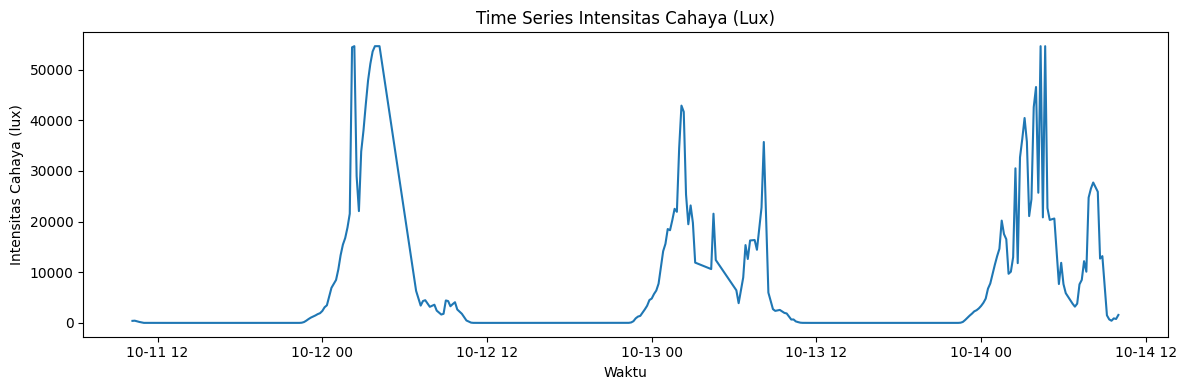

In [10]:

# Plot time series lux terhadap waktu
plt.figure(figsize=(12, 4))
plt.plot(df["time"], df["lux"])
plt.xlabel("Waktu")
plt.ylabel("Intensitas Cahaya (lux)")
plt.title("Time Series Intensitas Cahaya (Lux)")
plt.tight_layout()
plt.show()


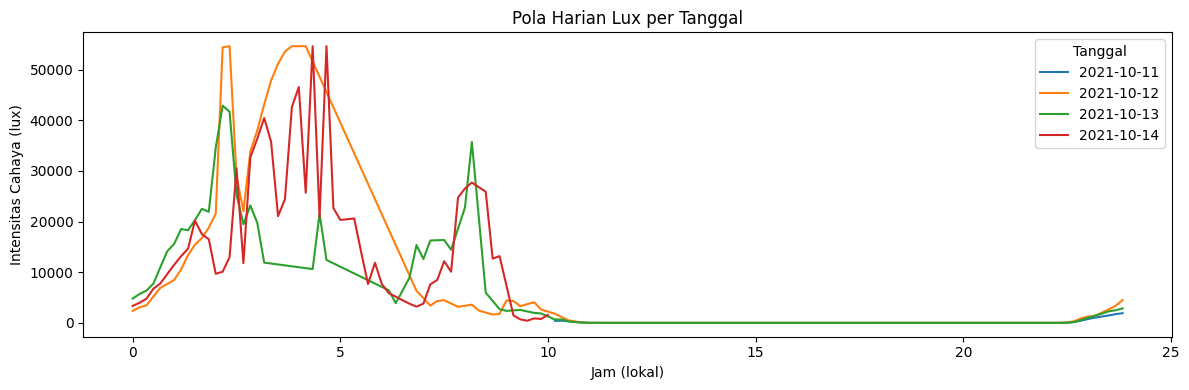

In [11]:

# Tambahkan kolom tanggal dan jam untuk melihat pola harian
df["date"] = df["time"].dt.date
df["hour"] = df["time"].dt.hour + df["time"].dt.minute / 60.0

# Plot pola harian: lux vs hour untuk tiap hari
plt.figure(figsize=(12, 4))

for d, sub in df.groupby("date"):
    plt.plot(sub["hour"], sub["lux"], label=str(d))

plt.xlabel("Jam (lokal)")
plt.ylabel("Intensitas Cahaya (lux)")
plt.title("Pola Harian Lux per Tanggal")
plt.legend(title="Tanggal")
plt.tight_layout()
plt.show()



**Interpretasi singkat EDA:**

- Nilai **lux** cenderung:
  - Hampir **0** pada malam hari
  - Meningkat tajam saat pagi menjelang siang
  - Menurun kembali menjelang sore–malam
- Pola ini **berulang harian**, sehingga wajar jika kita memodelkan lux dengan fungsi periodik (misalnya sinusoidal) yang mewakili siklus siang–malam.

Pola tersebut menginspirasi bentuk **model ODE** yang akan kita gunakan pada bagian berikutnya.



## 5. Formulasi Model ODE

Kita memodelkan intensitas cahaya **lux** sebagai suatu besaran dinamis \( L(t) \) yang:

- Berusaha mengejar suatu **nilai kesetimbangan (equilibrium)** \( L_{eq}(t) \) yang berubah periodik harian (akibat rotasi bumi / pergerakan matahari).
- Perubahan \( L(t) \) mengikuti persamaan relaksasi:

\[
\frac{dL}{dt} = -k \big( L(t) - L_{eq}(t) \big)
\]

dengan:

- \( k > 0 \) : kecepatan respon sistem menuju kesetimbangan
- \( L_{eq}(t) \) : kita ambil sebagai fungsi sinusoidal harian sederhana, dimodifikasi agar **tidak negatif** (karena lux \( \ge 0 \)).

Bentuk fungsi kesetimbangan yang digunakan:

\[
L_{eq}(t) = \max\big( 0, A \cdot \sin(2\pi t / 24 + \varphi) + C \big)
\]

dengan parameter:

- \( A \) : amplitudo (seberapa terang maksimum siang hari)
- \( C \) : offset (baseline)
- \( \varphi \) : fase (menggeser posisi puncak siang)

> **Tujuan utama pemodelan:**  
> Mencari parameter \( (k, A, C, \varphi) \) yang membuat kurva simulasi \( L(t) \) **mendekati data lux riil** (time series dari sensor).



### 5.1. Implementasi Fungsi Kesetimbangan dan ODE

Pertama kita definisikan:

- Fungsi \( L_{eq}(t) \)
- Fungsi turunan ODE \( f(t, L) = dL/dt \)


In [12]:

def L_eq(t_hours: np.ndarray, A: float, C: float, phi: float) -> np.ndarray:
    """
    Fungsi kesetimbangan (equilibrium) harian.
    
    Parameter
    ---------
    t_hours : array-like
        Waktu dalam jam (relatif terhadap t0).
    A : float
        Amplitudo (skala maksimal lux siang hari).
    C : float
        Offset (baseline lux).
    phi : float
        Fase (menggeser posisi puncak siang).
    """
    # t_hours bisa berupa array atau skalar; kita gunakan numpy untuk operasi vektor
    t_hours = np.asarray(t_hours)
    # Siklus harian 24 jam
    omega = 2 * np.pi / 24.0
    raw = A * np.sin(omega * t_hours + phi) + C
    # Pastikan nilai tidak negatif (lux >= 0)
    return np.maximum(0.0, raw)


def dL_dt(t: float, L: float, k: float, A: float, C: float, phi: float) -> float:
    """
    Turunan ODE: dL/dt = -k (L - L_eq(t)).
    """
    return -k * (L - float(L_eq(t, A, C, phi)))



### 5.2. Implementasi Metode RK4 untuk ODE Skalar

Metode **Runge–Kutta Orde 4 (RK4)** adalah metode standar untuk menyelesaikan ODE secara numerik.

Skema langkah tunggal:

\[
\begin{aligned}
k_1 &= f(t_n, y_n) \\
k_2 &= f\left(t_n + \frac{\Delta t}{2}, y_n + \frac{\Delta t}{2}k_1 \right) \\
k_3 &= f\left(t_n + \frac{\Delta t}{2}, y_n + \frac{\Delta t}{2}k_2 \right) \\
k_4 &= f\left(t_n + \Delta t, y_n + \Delta t\,k_3 \right) \\
y_{n+1} &= y_n + \frac{\Delta t}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{aligned}
\]

Kita implementasikan RK4 untuk kasus skalar \( L(t) \).


In [13]:

def rk4_step(t: float, L: float, dt: float, k: float, A: float, C: float, phi: float) -> float:
    """
    Melakukan satu langkah metode RK4 untuk ODE skalar L(t).
    
    Parameters
    ----------
    t : float
        Waktu saat ini (jam).
    L : float
        Nilai L(t) saat ini.
    dt : float
        Langkah waktu (delta t).
    k, A, C, phi : float
        Parameter model.
    """
    k1 = dL_dt(t, L, k, A, C, phi)
    k2 = dL_dt(t + 0.5 * dt, L + 0.5 * dt * k1, k, A, C, phi)
    k3 = dL_dt(t + 0.5 * dt, L + 0.5 * dt * k2, k, A, C, phi)
    k4 = dL_dt(t + dt, L + dt * k3, k, A, C, phi)
    return L + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)


def simulate_lux(time_hours: np.ndarray, L0: float, k: float, A: float, C: float, phi: float) -> np.ndarray:
    """
    Mensimulasikan lux L(t) untuk grid waktu 'time_hours' menggunakan RK4.
    
    Parameters
    ----------
    time_hours : array-like
        Grid waktu (jam) dalam urutan meningkat.
    L0 : float
        Kondisi awal L(t0).
    k, A, C, phi : float
        Parameter model.
    
    Returns
    -------
    L_sim : np.ndarray
        Nilai simulasi L pada setiap titik waktu di time_hours.
    """
    time_hours = np.asarray(time_hours)
    n = len(time_hours)
    L_sim = np.zeros(n)
    L_sim[0] = L0
    
    for i in range(n - 1):
        t = time_hours[i]
        dt = time_hours[i + 1] - time_hours[i]
        L_sim[i + 1] = rk4_step(t, L_sim[i], dt, k, A, C, phi)
    
    return L_sim



## 6. Fitting Parameter Model ke Data (Training & Testing)

Agar model kita **mendekati data riil**, kita perlu mencari parameter \( (k, A, C, \varphi) \) yang meminimalkan error antara:

- **Data riil lux**: \( L_{data}(t_i) \)
- **Simulasi model**: \( L_{sim}(t_i) \)

Metode yang digunakan di sini:

1. Membagi data menjadi **training** dan **testing** (misalnya 2 hari pertama untuk training, sisanya testing).
2. Mendefinisikan **fungsi loss** (Mean Squared Error / MSE).
3. Melakukan **grid search sederhana** di ruang parameter untuk menemukan kombinasi parameter terbaik.
   - Teknik ini memang bukan yang paling hemat waktu, tetapi **jelas dan mudah dijelaskan di laporan** (plus aman untuk praktikum).

> Catatan: Untuk proyek yang lebih besar, bisa digunakan optimisasi numerik (misalnya `scipy.optimize`), tapi grid search sudah cukup untuk dataset kecil ini.


In [14]:

# Siapkan array waktu dan target data
time_hours = df["time_hours"].values
lux_data = df["lux"].values

# Bagi menjadi train (misal 2 hari pertama) dan test (sisanya)
max_train_hours = 48.0  # 2 hari
train_mask = time_hours <= max_train_hours
test_mask = time_hours > max_train_hours

print("Jumlah data train:", train_mask.sum())
print("Jumlah data test :", test_mask.sum())


Jumlah data train: 289
Jumlah data test : 143


In [15]:

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Hitung Mean Squared Error (MSE)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean((y_true - y_pred) ** 2))


def evaluate_params(k: float, A: float, C: float, phi: float) -> float:
    """
    Menghitung MSE pada data training untuk parameter tertentu.
    """
    L0 = lux_data[0]  # kondisi awal dari data riil
    L_sim = simulate_lux(time_hours, L0, k, A, C, phi)
    return mse(lux_data[train_mask], L_sim[train_mask])



### 6.1. Grid Search Parameter

Kita definisikan rentang parameter yang masuk akal berdasarkan hasil EDA:

- \( k \) : kecepatan relaksasi (misalnya 0.01 s.d. 1.0)
- \( A \) : amplitudo lux (sekitar skala maksimum lux observasi)
- \( C \) : offset (bisa negatif kecil sampai positif sedang)
- \( \varphi \) : fase dalam radian (\(-\pi\) sampai \(\pi\))

Kita gunakan grid yang tidak terlalu halus agar waktu komputasi tetap wajar.


In [16]:

# Tentukan rentang parameter untuk grid search
lux_max = lux_data.max()

k_values = np.linspace(0.05, 1.0, 8)                 # 8 nilai antara 0.05 dan 1.0
A_values = np.linspace(lux_max * 0.5, lux_max * 1.5, 8)  # 8 nilai sekitar skala lux maksimum
C_values = np.linspace(-0.1 * lux_max, 0.3 * lux_max, 6) # 6 nilai offset
phi_values = np.linspace(-np.pi, np.pi, 8)               # 8 nilai fase

print("Ukuran grid:")
print("k   :", len(k_values))
print("A   :", len(A_values))
print("C   :", len(C_values))
print("phi :", len(phi_values))

total_comb = len(k_values) * len(A_values) * len(C_values) * len(phi_values)
print("Total kombinasi parameter:", total_comb)


Ukuran grid:
k   : 8
A   : 8
C   : 6
phi : 8
Total kombinasi parameter: 3072


In [17]:

# Lakukan grid search
best_params = None
best_loss = np.inf

counter = 0
for k in k_values:
    for A in A_values:
        for C in C_values:
            for phi in phi_values:
                counter += 1
                loss = evaluate_params(k, A, C, phi)
                if loss < best_loss:
                    best_loss = loss
                    best_params = (k, A, C, phi)

print("Selesai grid search.")
print("Jumlah kombinasi yang dievaluasi:", counter)
print("Best loss (MSE train):", best_loss)
print("Best params (k, A, C, phi):", best_params)


Selesai grid search.
Jumlah kombinasi yang dievaluasi: 3072
Best loss (MSE train): 76836362.19576094
Best params (k, A, C, phi): (np.float64(0.3214285714285714), np.float64(35108.03571428572), np.float64(-5461.25), np.float64(-2.243994752564138))


In [18]:

# Simulasikan ulang dengan parameter terbaik
k_best, A_best, C_best, phi_best = best_params
L0 = lux_data[0]
L_sim_best = simulate_lux(time_hours, L0, k_best, A_best, C_best, phi_best)

# Hitung error train dan test
mse_train = mse(lux_data[train_mask], L_sim_best[train_mask])
mse_test = mse(lux_data[test_mask], L_sim_best[test_mask])

print("MSE (train):", mse_train)
print("MSE (test) :", mse_test)


MSE (train): 76836362.19576094
MSE (test) : 68607783.66659425



## 7. Visualisasi Hasil Simulasi vs Data Riil

Pada bagian ini, kita membandingkan:

- Kurva **data riil lux** (sensor)
- Kurva **simulasi model ODE + RK4** dengan parameter terbaik (hasil fitting)

Kita juga menampilkan grafik residual (selisih data - simulasi) untuk melihat pola error.


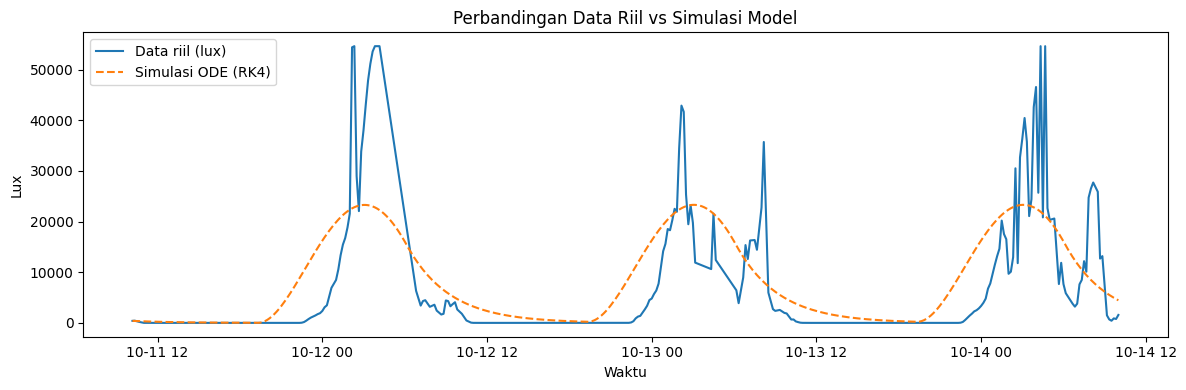

In [19]:

plt.figure(figsize=(12, 4))
plt.plot(df["time"], lux_data, label="Data riil (lux)")
plt.plot(df["time"], L_sim_best, label="Simulasi ODE (RK4)", linestyle="--")
plt.xlabel("Waktu")
plt.ylabel("Lux")
plt.title("Perbandingan Data Riil vs Simulasi Model")
plt.legend()
plt.tight_layout()
plt.show()


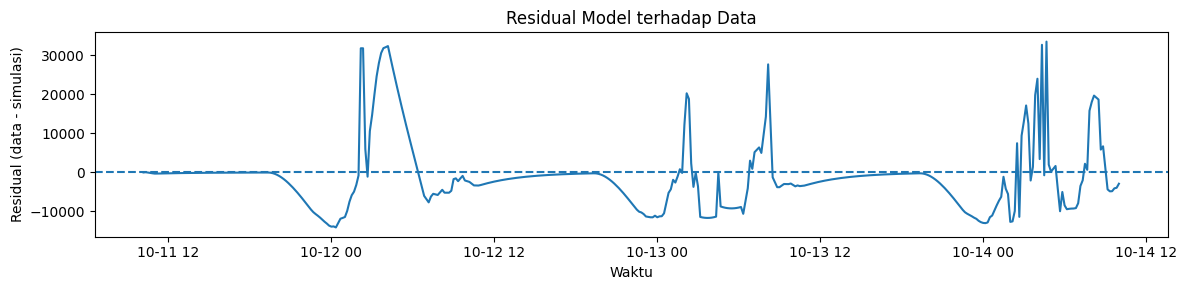

In [20]:

# Plot residual (data - simulasi)
residuals = lux_data - L_sim_best

plt.figure(figsize=(12, 3))
plt.plot(df["time"], residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("Waktu")
plt.ylabel("Residual (data - simulasi)")
plt.title("Residual Model terhadap Data")
plt.tight_layout()
plt.show()



**Interpretasi singkat hasil:**

- Jika kurva simulasi cukup menempel pada kurva data riil, berarti model sederhana kita sudah cukup baik menangkap pola siang–malam pada intensitas cahaya.
- Nilai MSE (train dan test) dapat disebutkan di laporan sebagai ukuran **goodness-of-fit**.
- Pola residual yang masih terstruktur (misalnya ada jam tertentu di mana error selalu besar) bisa menjadi bahan diskusi:
  - Adanya awan / hujan / shading bangunan yang tidak tertangkap oleh model sederhana.
  - Sensor noise atau efek lain yang tidak dimodelkan.

Bagian ini sangat penting untuk **bab Hasil & Pembahasan** di laporan jurnal.



## 8. Fungsi Utilitas untuk Deployment (Streamlit)

Sebagai persiapan untuk **deployment Streamlit**, kita bisa membungkus simulasi ke dalam fungsi utilitas yang:

- Menerima parameter \( k, A, C, \varphi \)
- Mengembalikan `DataFrame` berisi waktu dan hasil simulasi

Sehingga di file `app.py` (Streamlit) nanti kita bisa:

- Menambahkan **slider** untuk parameter
- Memanggil fungsi simulasi ini
- Menampilkan grafik interaktif (what-if analysis)


In [21]:

def run_simulation_df(k: float, A: float, C: float, phi: float) -> pd.DataFrame:
    """
    Menjalankan simulasi dan mengembalikan DataFrame berisi waktu, lux data, dan lux simulasi.
    """
    L0 = lux_data[0]
    L_sim = simulate_lux(time_hours, L0, k, A, C, phi)
    
    result = pd.DataFrame({
        "time": df["time"],
        "lux_data": lux_data,
        "lux_sim": L_sim
    })
    return result

# Contoh pemanggilan (menggunakan parameter terbaik)
df_sim_example = run_simulation_df(k_best, A_best, C_best, phi_best)
df_sim_example.head()


,time,lux_data,lux_sim
0,2021-10-11 10:10:00+00:00,398.333300,398.333300
1,2021-10-11 10:20:00+00:00,435.000000,377.555534
2,2021-10-11 10:30:00+00:00,311.666650,357.861572
3,2021-10-11 10:40:00+00:00,188.333300,339.194883
4,2021-10-11 10:50:00+00:00,96.249983,321.501881



## 10. Integrasi Data Prakiraan Cuaca BMKG (Kabupaten Bandung)

Pada bagian ini kita menambahkan **sumber data kedua** dari **API resmi BMKG** untuk:

- Mengambil **prakiraan cuaca 3 harian** untuk salah satu kelurahan di **Kabupaten Bandung**  
  (kode wilayah tingkat IV: `32.04.29.2001`).
- Mengolah data JSON BMKG menjadi `DataFrame` pandas.
- Melakukan **EDA singkat** terhadap variabel cuaca (suhu, kelembapan, tutupan awan, dll.).

> **Catatan penting untuk laporan:**  
> - Data utama untuk **fitting model ODE** tetap berasal dari `lux.csv` (IoT / Kaggle).  
> - Data BMKG ini digunakan sebagai **tambahan** untuk menunjukkan integrasi data publik dan
>   konteks cuaca di wilayah sekitar, sehingga menjadi **nilai plus** pada tugas.


In [22]:

import requests

bmkg_url = "https://api.bmkg.go.id/publik/prakiraan-cuaca?adm4=32.04.29.2001"
print("Endpoint BMKG:", bmkg_url)

try:
    response = requests.get(bmkg_url, timeout=10)
    response.raise_for_status()
    data_bmkg = response.json()
    print("Berhasil mengambil data BMKG.")
    print("Key di level teratas:", list(data_bmkg.keys()))
except Exception as e:
    print("Gagal mengambil data BMKG:", e)
    data_bmkg = None


Endpoint BMKG: https://api.bmkg.go.id/publik/prakiraan-cuaca?adm4=32.04.29.2001
Berhasil mengambil data BMKG.
Key di level teratas: ['lokasi', 'data']


In [23]:

# Flatten struktur JSON BMKG menjadi DataFrame
if data_bmkg is not None:
    lokasi_global = data_bmkg.get("lokasi", {})
    records = []

    for entry in data_bmkg.get("data", []):
        lokasi_entry = entry.get("lokasi", {})
        cuaca_lists = entry.get("cuaca", [])  # list-of-lists (3 hari x 8 waktu)
        for daily_list in cuaca_lists:
            for row in daily_list:
                rec = {}
                # informasi lokasi umum
                rec.update(lokasi_global)
                # informasi lokasi detail (adm4)
                rec.update(lokasi_entry)
                # informasi cuaca pada suatu waktu (t, hu, tp, tcc, dll.)
                rec.update(row)
                records.append(rec)

    df_bmkg = pd.DataFrame(records)
    print("Ukuran df_bmkg:", df_bmkg.shape)
    display(df_bmkg.head())
else:
    df_bmkg = None
    print("df_bmkg tidak terbentuk karena data_bmkg None.")


Ukuran df_bmkg: (20, 31)


,adm1,adm2,adm3,adm4,provinsi,kotkab,kecamatan,desa,lon,lat,timezone,type,datetime,t,tcc,tp,weather,weather_desc,weather_desc_en,wd_deg,wd,wd_to,ws,hu,vs,vs_text,time_index,analysis_date,image,utc_datetime,local_datetime
0,32,32.04,32.04.29,32.04.29.2001,Jawa Barat,Bandung,Ciparay,Ciparay,107.720069,-7.025371,+0700,adm4,2026-01-19T06:00:00Z,28,100,4.5,61,Hujan Ringan,Light Rain,254,SW,NE,14.6,81,10006,> 10 km,5-6,2026-01-19T00:00:00,https://api-apps.bmkg.go.id/storage/icon/cuaca...,2026-01-19 06:00:00,2026-01-19 13:00:00
1,32,32.04,32.04.29,32.04.29.2001,Jawa Barat,Bandung,Ciparay,Ciparay,107.720069,-7.025371,+0700,adm4,2026-01-19T09:00:00Z,23,100,0.0,3,Berawan,Mostly Cloudy,250,SW,NE,9.3,91,6990,< 7 km,8-9,2026-01-19T00:00:00,https://api-apps.bmkg.go.id/storage/icon/cuaca...,2026-01-19 09:00:00,2026-01-19 16:00:00
2,32,32.04,32.04.29,32.04.29.2001,Jawa Barat,Bandung,Ciparay,Ciparay,107.720069,-7.025371,+0700,adm4,2026-01-19T12:00:00Z,23,100,0.0,3,Berawan,Mostly Cloudy,232,SW,NE,4.0,96,10003,> 10 km,11-12,2026-01-19T00:00:00,https://api-apps.bmkg.go.id/storage/icon/cuaca...,2026-01-19 12:00:00,2026-01-19 19:00:00
3,32,32.04,32.04.29,32.04.29.2001,Jawa Barat,Bandung,Ciparay,Ciparay,107.720069,-7.025371,+0700,adm4,2026-01-19T15:00:00Z,22,100,0.0,3,Berawan,Mostly Cloudy,213,S,N,3.3,92,9998,< 10 km,14-15,2026-01-19T00:00:00,https://api-apps.bmkg.go.id/storage/icon/cuaca...,2026-01-19 15:00:00,2026-01-19 22:00:00
4,32,32.04,32.04.29,32.04.29.2001,Jawa Barat,Bandung,Ciparay,Ciparay,107.720069,-7.025371,+0700,adm4,2026-01-19T18:00:00Z,21,100,0.0,3,Berawan,Mostly Cloudy,234,SW,NE,3.4,93,10000,< 11 km,17-18,2026-01-19T00:00:00,https://api-apps.bmkg.go.id/storage/icon/cuaca...,2026-01-19 18:00:00,2026-01-20 01:00:00


In [24]:

# Konversi kolom waktu ke datetime dan urutkan
if df_bmkg is not None and not df_bmkg.empty:
    for col in ["datetime", "utc_datetime", "local_datetime", "analysis_date"]:
        if col in df_bmkg.columns:
            df_bmkg[col] = pd.to_datetime(df_bmkg[col], errors="coerce")
    
    if "local_datetime" in df_bmkg.columns:
        df_bmkg = df_bmkg.sort_values("local_datetime").reset_index(drop=True)
    
    print(df_bmkg[["local_datetime", "t", "hu", "tcc", "tp", "weather_desc"]].head())
else:
    print("df_bmkg kosong atau None.")


       local_datetime   t  hu  tcc   tp  weather_desc
0 2026-01-19 13:00:00  28  81  100  4.5  Hujan Ringan
1 2026-01-19 16:00:00  23  91  100  0.0       Berawan
2 2026-01-19 19:00:00  23  96  100  0.0       Berawan
3 2026-01-19 22:00:00  22  92  100  0.0       Berawan
4 2026-01-20 01:00:00  21  93  100  0.0       Berawan



### 10.1. EDA Singkat Data BMKG

Di sini kita melihat pola **suhu** (`t`), **tutupan awan** (`tcc`), dan **curah hujan prakiraan** (`tp`)
terhadap waktu lokal. Data ini merupakan **prakiraan** per 3 jam untuk 3 hari ke depan.


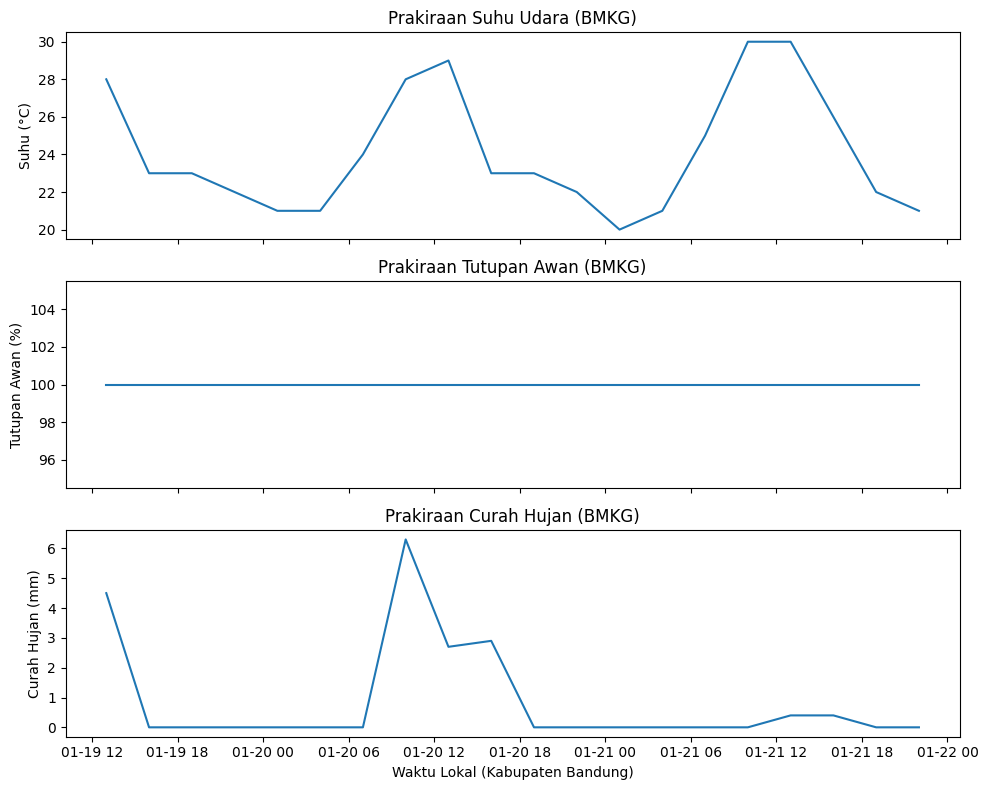

In [25]:

if df_bmkg is not None and not df_bmkg.empty and "local_datetime" in df_bmkg.columns:
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    
    # Suhu udara
    if "t" in df_bmkg.columns:
        axs[0].plot(df_bmkg["local_datetime"], df_bmkg["t"])
        axs[0].set_ylabel("Suhu (°C)")
        axs[0].set_title("Prakiraan Suhu Udara (BMKG)")
    
    # Tutupan awan
    if "tcc" in df_bmkg.columns:
        axs[1].plot(df_bmkg["local_datetime"], df_bmkg["tcc"])
        axs[1].set_ylabel("Tutupan Awan (%)")
        axs[1].set_title("Prakiraan Tutupan Awan (BMKG)")
    
    # Curah hujan prakiraan
    if "tp" in df_bmkg.columns:
        axs[2].plot(df_bmkg["local_datetime"], df_bmkg["tp"])
        axs[2].set_ylabel("Curah Hujan (mm)")
        axs[2].set_title("Prakiraan Curah Hujan (BMKG)")
    
    axs[2].set_xlabel("Waktu Lokal (Kabupaten Bandung)")
    fig.tight_layout()
    plt.show()
else:
    print("Tidak ada kolom 'local_datetime' atau df_bmkg kosong.")



### 10.2. Catatan untuk Laporan / Presentasi

Beberapa poin yang dapat Anda gunakan di **bab Metodologi / Hasil & Pembahasan**:

- Selain menggunakan data `lux.csv` sebagai dasar pemodelan intensitas cahaya, proyek ini juga
  mengintegrasikan **API Prakiraan Cuaca BMKG** untuk wilayah Kabupaten Bandung.
- Data BMKG menyediakan informasi seperti suhu udara (`t`), kelembapan (`hu`), tutupan awan (`tcc`),
  dan curah hujan prakiraan (`tp`) per 3 jam selama 3 hari.
- Integrasi ini menunjukkan bahwa model dapat diperluas untuk:

  - Mengkaitkan pola lux dengan variabel cuaca (misalnya tutupan awan dan hujan).
  - Menyediakan konteks cuaca saat melakukan interpretasi hasil simulasi lux.
  - Menjadi dasar pengembangan model yang lebih kompleks (misalnya menambahkan pengaruh `tcc`/`tp`
    ke dalam persamaan ODE di masa depan).

Dengan tambahan ini, notebook Anda tidak hanya memenuhi syarat **Jalur 1 (ODE + RK4 + data riil)**,
tetapi juga menunjukkan kemampuan untuk mengkonsumsi **data publik resmi (BMKG)** secara langsung.
